In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import json
import copy
import datetime
import pandas as pd


def calc_import_export_costs(grid_import_export, elec_tariffs):
    day_ahead_price = elec_tariffs["day_ahead_price"]
    capacity_tariff = elec_tariffs["capacity_tariff"]
    exp_cap_tar = capacity_tariff * 12 / 30
    kwh_offtake_cost = elec_tariffs["kwh_offtake_cost"]
    year_cost = elec_tariffs["year_cost"]
    injection_extra = elec_tariffs["injection_extra"]
    offtake_extra = elec_tariffs["offtake_extra"]
    time_step_h = elec_tariffs["time_step_h"]

    day_ahead_cost = 0
    offtake_cost = 0
    capacity_cost = 0
    constant_cost = 0

    constant_cost = -2.5 * exp_cap_tar
    max_grid_peak = 2.5

    day_ahead_hist = list()
    offtake_hist = list()
    capacity_hist = list()
    constant_hist = list()

    for i in range(len(grid_import_export["import"])):

        grid_import = grid_import_export["import"][i] * time_step_h
        grid_export = grid_import_export["export"][i] * time_step_h
        dt_str = grid_import_export["datetime"][i]
        dt = datetime.datetime.strptime(dt_str, "%Y-%m-%dT%H:%M:%SZ")

        if dt.hour == 15 and dt.minute == 0:
            day_ahead_hist.append(0)
            offtake_hist.append(0)
            capacity_hist.append(0)
            constant_hist.append(0)

        price_ind = day_ahead_price["datetime"].index(dt_str)
        cur_day_ahead_price = day_ahead_price["values"][price_ind]

        day_ahead_price_import = cur_day_ahead_price + offtake_extra
        if day_ahead_price_import > 0:
            day_ahead_cost += -grid_import * day_ahead_price_import * 1.06
        else:
            day_ahead_cost += -grid_import * day_ahead_price_import

        day_ahead_price_export = cur_day_ahead_price + injection_extra
        day_ahead_cost += day_ahead_price_export * grid_export
        day_ahead_hist[-1] = day_ahead_cost

        offtake_cost += -kwh_offtake_cost * grid_import
        offtake_hist[-1] = offtake_cost
        cur_grid_peak = grid_import / time_step_h

        if cur_grid_peak > max_grid_peak:
            capacity_cost += -(cur_grid_peak - max_grid_peak) * exp_cap_tar
            max_grid_peak = cur_grid_peak
        capacity_hist[-1] = capacity_cost

        constant_cost += -year_cost / 365 / 24 * time_step_h
        constant_hist[-1] = constant_cost

    costs = {
        "day_ahead": day_ahead_hist,
        "offtake": offtake_hist,
        "capacity": capacity_hist,
        "constant": constant_hist,
    }
    return costs


def calc_from_logs(log_folder, single_val_grid=False):
    houses = [1, 2, 3, 5]
    emss = ["RL", "RBC", "Tree", "MPC"]
    elec_tariffs = json.load(open(f"{log_folder}elec_tariffs.json", "r"))

    different_costs = ["day_ahead", "offtake", "capacity", "constant"]

    real_result = {ems: {cost_type: 0 for cost_type in different_costs} for ems in emss}
    for ems in emss:
        for cost_type in different_costs:
            real_result[ems][f"{cost_type}_hist"] = list()

    simul_result = copy.deepcopy(real_result)

    for house_num in houses:
        print(f"Costs house {house_num}")
        for ems in emss:
            house_ems_file = f"{log_folder}house_{house_num}_{ems}_grid.csv"

            result_data = pd.read_csv(house_ems_file).to_dict(orient="list")
            datetimes = result_data["datetime"]
            if single_val_grid:
                single_power = [
                    p - result_data["grid_export"][i]
                    for i, p in enumerate(result_data["grid_import"])
                ]
                single_import = [p if p > 0 else 0 for p in single_power]
                single_export = [-p if p < 0 else 0 for p in single_power]
                real_grid = {
                    "datetime": datetimes,
                    "import": single_import,
                    "export": single_export,
                }
            else:
                real_grid = {
                    "datetime": datetimes,
                    "import": result_data["grid_import"],
                    "export": result_data["grid_export"],
                }

            real_cost = calc_import_export_costs(real_grid, elec_tariffs)

            tot_cost = 0
            for cost_type in real_cost.keys():
                real_result[ems][f"{cost_type}_hist"] += real_cost[cost_type]
                cur_cost = real_cost[cost_type][-1]
                real_result[ems][cost_type] += cur_cost
                tot_cost += cur_cost

            print(f"{ems} real: {tot_cost}")

            simul_import = [p if p > 0 else 0 for p in result_data["grid_power"]]
            simul_export = [-p if p < 0 else 0 for p in result_data["grid_power"]]
            simul_grid = {
                "datetime": datetimes,
                "import": simul_import,
                "export": simul_export,
            }

            simul_cost = calc_import_export_costs(simul_grid, elec_tariffs)

            tot_cost = 0
            for cost_type in simul_cost.keys():
                simul_result[ems][f"{cost_type}_hist"] += simul_cost[cost_type]
                cur_cost = simul_cost[cost_type][-1]
                simul_result[ems][cost_type] += cur_cost
                tot_cost += cur_cost

            print(f"{ems} simul: {tot_cost}")

    return real_result, simul_result


def sum_hist_cost(hist_cost, remove_capacity=False):
    tot_cost = None
    if remove_capacity:
        costs = ["day_ahead", "offtake"]
    else:
        costs = ["day_ahead", "offtake", "capacity", "constant"]
    for cost in costs:
        cost_hist = hist_cost[f"{cost}_hist"]
        if tot_cost is None:
            tot_cost = -np.array(cost_hist)
        else:
            tot_cost += -np.array(cost_hist)
    return tot_cost


def sum_to_non_cumul(tot_cost):
    non_cumul = []
    num_days = int(tot_cost.shape[0] / 4)
    for i in range(4):
        non_cumul.append(tot_cost[i * num_days])
        for j in range(1, num_days):
            non_cumul.append(
                tot_cost[i * num_days + j] - tot_cost[i * num_days + j - 1]
            )

    return np.array(non_cumul)


def plot_cost_comparison(all_costs, remove_capacity=False):
    to_compare = ["Simul", "Perfect"]

    algos_to_plot = ["MPC", "RL", "RBC", "Tree"]
    costs = ["day_ahead", "offtake", "capacity", "constant"]

    for comp in to_compare:
        for algo in algos_to_plot:
            plt.figure()

            comp_cost = sum_hist_cost(all_costs[comp][algo], remove_capacity)
            real_cost = sum_hist_cost(all_costs["Real"][algo], remove_capacity)
            plt.plot(comp_cost, label=comp)
            plt.plot(real_cost, label="Real")
            # Seperate the figure in 4 equal parts with vertical separators
            num_days = int(comp_cost.shape[0] / 4)
            for i in range(1, 4):
                plt.axvline(x=i * num_days - 0.5, color="red", linestyle="--")
            plt.title(f"{algo} {comp}")
            plt.ylabel("Cumulative cost (€)")
            plt.legend()

            # Difference
            plt.figure()

            comp_non_cuml = sum_to_non_cumul(comp_cost)
            real_non_cumul = sum_to_non_cumul(real_cost)
            diff_cost = comp_non_cuml - real_non_cumul
            x = np.arange(len(diff_cost))
            plt.scatter(x, diff_cost)
            num_days = int(comp_cost.shape[0] / 4)
            for i in range(1, 4):
                plt.axvline(x=i * num_days - 0.5, color="red", linestyle="--")

            # Plot a horizontal line at 0, very thin
            plt.axhline(0, color="black", linewidth=0.5)
            plt.ylabel("Difference cost for each day (€)")

            # plt.ylim(-5, 5)

            plt.title(f"{algo} {comp} - Real")


def plot_side_stack_bar(all_costs):

    stacked_bar_plots = dict()
    emss = ["RL", "RBC", "Tree", "MPC"]
    cost_types = ["day_ahead", "offtake", "capacity", "constant"]

    plt.figure(figsize=(6.5, 5))

    ind = np.arange(len(emss))
    width = 0.5 / len(all_costs.keys())

    # Give me the first four colors of the matplotlib color cycle
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"][:4]

    for key, values in all_costs.items():
        stacked_bar_plots[key] = {c: [0 for _ in emss] for c in cost_types}

        for i, ems in enumerate(emss):
            for j, cost_type in enumerate(cost_types):
                stacked_bar_plots[key][cost_type][i] = -values[ems][cost_type]

        bottom = np.array([0.0 for _ in emss])
        for key_2, weight_count in stacked_bar_plots[key].items():
            ind_key = list(all_costs.keys()).index(key)
            ind_color = list(stacked_bar_plots[key].keys()).index(key_2)
            if ind_key == 0:
                label = key_2
            else:
                label = None
            if key == "Real":
                hatch = None
            elif key == "Simul":
                hatch = "//"
            elif key == "Perfect":
                hatch = "//"

            if key == "Perfect":

                x_pos = ind + width * ind_key + 0.1
            else:
                x_pos = ind + width * ind_key
            p = plt.bar(
                x_pos,
                weight_count,
                width,
                label=label,
                bottom=bottom,
                color=colors[ind_color],
                hatch=hatch,
                edgecolor="black",
            )

            bottom += np.array(weight_count)

    xticks_add = (len(all_costs.keys()) - 1) * width / 2
    xticks_add = width / 2
    xticks_perf = ind + 2 * width + 0.1
    all_ticks = list(ind + xticks_add) + list(xticks_perf)
    emss_perf = emss + ["MPC P"] * 4
    plt.xticks(all_ticks, emss_perf)

    ax = plt.gca()  # Define the variable "ax" as the current axes object
    handles, labels = ax.get_legend_handles_labels()

    # manually define a new patch
    patch = mpatches.Patch(facecolor="white", label="Real", edgecolor="black")
    simul_patch = mpatches.Patch(
        facecolor="white", label="Simulation", hatch="//", edgecolor="black"
    )
    # perfect_patch = mpatches.Patch(
    #    facecolor="white", label="Perfect forecast MPC", hatch="x", edgecolor="black"
    # )

    # handles is a list, so append manual patch
    handles = handles[::-1]
    handles.append(patch)
    handles.append(simul_patch)
    handles.append(mpatches.Patch(facecolor="white"))
    # handles.append(perfect_patch)

    plt.ylabel("Total cost (€)")

    # plot the legend
    plt.legend(handles=handles, ncol=2)
    plt.tight_layout()
    if False:
        plt.savefig(
            "/home/django/Documents/Thesis_MOBI/InterConnect/652d084deb12ec3cd4be564b/figures/comparions_costs.pdf"
        )


def calc_diff_single_import_export(log_folder):

    real_costs, _ = calc_from_logs(log_folder, single_val_grid=False)

    real_costs_single, _ = calc_from_logs(log_folder, single_val_grid=True)

    costs = ["day_ahead", "offtake", "capacity", "constant"]
    emss = ["RL", "RBC", "Tree", "MPC"]
    for ems in emss:
        real_tot_cost = 0
        single_tot_cost = 0

        for cost in costs:
            real_tot_cost += real_costs[ems][cost]
            single_tot_cost += real_costs_single[ems][cost]
        print(f"{ems} real: {real_tot_cost}")
        print(f"{ems} single: {single_tot_cost}")

        diff = real_tot_cost - single_tot_cost
        print(f"{ems} diff: {diff}")


def plot_comparison_results(log_folder, plot_all_comparison=True):

    real_costs, simul_costs = calc_from_logs(log_folder)

    log_perfect = "results/experiment_1_perfect/"
    _, perfect_costs = calc_from_logs(log_perfect)

    all_costs = {"Real": real_costs, "Simul": simul_costs, "Perfect": perfect_costs}
    plot_side_stack_bar(all_costs)
    if plot_all_comparison:
        plot_cost_comparison(all_costs, remove_capacity=True)


def plot_original_comparison_result():
    log_folder = "results/experiment_1/"
    plot_comparison_results(log_folder)


def plot_bugmpc_comparison_result():
    log_folder = "results/bug_mpc/"
    plot_comparison_results(log_folder, plot_all_comparison=False)


In [2]:
# Initialize an empty dataframe
df_rewards_1 = pd.DataFrame()

for i in [1,2,3,5]:
    log_folder = 'results\\experiment_1\\'
    house_num = i
    ems = 'RL'

    elec_tariffs = json.load(open(f"{log_folder}elec_tariffs.json", "r"))

    house_ems_file = f"{log_folder}house_{house_num}_{ems}_grid.csv"

    result_data = pd.read_csv(house_ems_file).to_dict(orient="list")
    datetimes = result_data["datetime"]

    real_grid = {
            "datetime": datetimes,
            "import": result_data["grid_import"],
            "export": result_data["grid_export"],
        }

    real_cost = calc_import_export_costs(real_grid, elec_tariffs)

    reward_per_day = np.diff((np.array(real_cost['day_ahead']) + np.array(real_cost['offtake'])) * 100, prepend=0)

    # Add reward_per_day as a column to the dataframe
    df_rewards_1[f"house_{house_num}"] = reward_per_day

In [5]:
df_rewards_1

,house_1,house_2,house_3,house_5
0,-516.149884,-164.936985,-471.107995,-171.693273
1,-573.816729,-395.296425,-246.261921,-221.319411
2,-314.763498,-151.671057,-415.382242,-148.433513
3,-260.346845,-289.900518,-282.601395,-280.997203
4,-155.512878,-135.684388,-379.045476,-527.892757
5,-553.110787,-102.868383,-576.458365,-455.593879
6,-92.276160,-116.703746,-696.958212,-568.221261
7,-265.666197,-78.167026,-577.365064,-725.589691
8,-494.622297,-297.128477,-204.429538,-501.419209
9,-167.586223,-193.284218,-620.791839,-244.477981


In [8]:
# Initialize an empty dataframe
df_rewards_2 = pd.DataFrame()

for i in [1,2,3,5]:
    log_folder = 'results\\experiment_1_perfect\\'
    house_num = i
    ems = 'RL'

    elec_tariffs = json.load(open(f"{log_folder}elec_tariffs.json", "r"))

    house_ems_file = f"{log_folder}house_{house_num}_{ems}_grid.csv"

    result_data = pd.read_csv(house_ems_file).to_dict(orient="list")
    datetimes = result_data["datetime"]

    simul_import = [p if p > 0 else 0 for p in result_data["grid_power"]]
    simul_export = [-p if p < 0 else 0 for p in result_data["grid_power"]]
    simul_grid = {
        "datetime": datetimes,
        "import": simul_import,
        "export": simul_export,
        }
    
    cost = calc_import_export_costs(simul_grid, elec_tariffs)

    reward_per_day = np.diff((np.array(cost['day_ahead']) + np.array(cost['offtake'])) * 100, prepend=0)

    # Add reward_per_day as a column to the dataframe
    df_rewards_2[f"house_{house_num}"] = reward_per_day


In [9]:
df_rewards_2

,house_1,house_2,house_3,house_5
0,-322.549448,24.966655,-212.511434,-19.986777
1,-502.805196,-278.555938,-63.961055,-151.536323
2,-220.307033,-35.010117,-203.090150,-47.778598
3,-128.052550,-174.530788,-119.520542,-209.660267
4,-8.848966,0.236197,-153.494990,-393.521404
5,-392.402988,-22.135300,-365.556552,-400.625579
6,16.982298,29.162803,-465.578889,-451.178335
7,-196.388268,44.820797,-335.453475,-563.216018
8,-349.474765,-167.421897,-56.106989,-422.982059
9,-105.946632,-41.859308,-430.424287,-182.752376


In [11]:
df_delta = df_rewards_1 - df_rewards_2
df_delta

,house_1,house_2,house_3,house_5
0,-193.600435,-189.903640,-258.596561,-151.706496
1,-71.011533,-116.740487,-182.300866,-69.783088
2,-94.456465,-116.660940,-212.292092,-100.654914
3,-132.294295,-115.369731,-163.080853,-71.336936
4,-146.663911,-135.920585,-225.550486,-134.371353
5,-160.707799,-80.733084,-210.901813,-54.968300
6,-109.258458,-145.866549,-231.379323,-117.042926
7,-69.277928,-122.987822,-241.911589,-162.373673
8,-145.147532,-129.706579,-148.322550,-78.437150
9,-61.639591,-151.424910,-190.367552,-61.725605


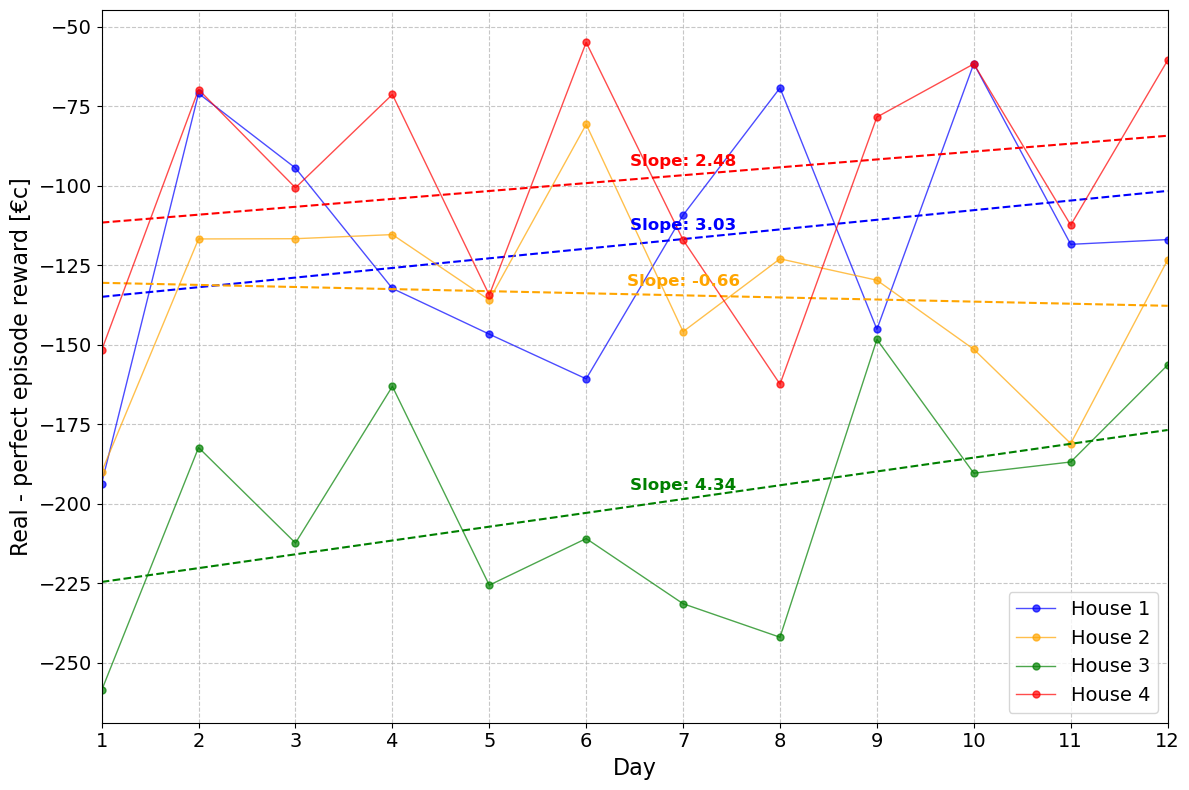

In [13]:
from scipy.stats import linregress

# Define a list of colors
color_list = ['blue', 'orange', 'green', 'red']

# Plotting
plt.figure(figsize=(12, 8))

# Plot original data and trend line for each house
for idx, column in enumerate(df_delta.columns):
    # Fit a linear trend line to each house's values
    slope, intercept, _, _, _ = linregress(df_delta.index + 1, df_delta[column])
    trend_line = intercept + slope * (df_delta.index + 1)
    
    # Use the same color for both data and trend line
    color = color_list[idx % len(color_list)]

    # Adjust label for house_5 to house_4
    if column == 'house_5':
        column_label = 'house_4'
    else:
        column_label = column
    
    column_label = f'House {int(column_label.split("_")[1])}'
    
    # Plot original data
    plt.plot(df_delta.index + 1, df_delta[column], marker='o', markersize=5, linestyle='-', color=color, label=f'{column_label}', linewidth=1, alpha=0.7)
    
    # Plot trend line with slightly brighter color
    plt.plot(df_delta.index + 1, trend_line, linestyle='--', color=color)
    
    # Calculate midpoint of the trend line
    midpoint_index = len(trend_line) // 2
    x_pos = df_delta.index[midpoint_index] + 1
    y_pos = trend_line[midpoint_index] + 2
    
    # Annotate the slope value in the middle of the trend line
    plt.text(x_pos, y_pos, f'Slope: {slope:.2f}', color=color, fontsize=12, verticalalignment='bottom', horizontalalignment='center', weight='bold')

# Add labels and title
plt.xlabel('Day', fontsize=16)
plt.ylabel('Real - perfect episode reward [€c]', fontsize=16)
#plt.title('Training Progress by House', fontsize=16)
plt.xticks(df_delta.index + 1)  # Adjust ticks to match index + 1
plt.legend(fontsize=14)

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)

# Limit x axis between 1 and 12
plt.xlim(1, 12)

# Adjust tick parameters
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=12)

# Show plot
plt.tight_layout()
plt.savefig('episode_rewards_minus_optimal.pdf')
plt.show()